In [1]:
from pathlib import Path
import argparse

In [2]:
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import tables
import matplotlib
import matplotlib.pyplot as plt
import mplhep as hep
from scipy import stats
from iminuit import Minuit
from iminuit.cost import LeastSquares

In [3]:
# Jupyter notebook
%matplotlib inline

# Shell
#matplotlib.use('Agg')

plt.style.use(hep.style.CMS)

### Define functions
* Single Gaussian
* Single Gaussian + constant

In [4]:
# Define functions that may be fit to the rates
def sg(x, peak, mean, cap_sigma):
    return peak*np.exp(-(x-mean)**2/(2*cap_sigma**2))

def sg_const(x, peak, mean, cap_sigma, constant):
    return sg(x, peak, mean, cap_sigma) + constant

In [5]:
# Each function needs a mapping from string given as a parameter, and also a set of initial conditions
FIT_FUNCTIONS = {
    'sg':       {'handle': sg,       'initial_values': {'peak': 1e-4, 'mean': 0, 'cap_sigma': 0.3}},
    'sg_const': {'handle': sg_const, 'initial_values': {'peak': 1e-4, 'mean': 0, 'cap_sigma': 0.3, 'constant': 0}}
}

### Required arguments
* Fit type
* pdf (T/F)
* luminometer
* file name(s)
* calibrate_beam_current (T/F)

In [6]:
from argparse import Namespace
args = Namespace(calibrate_beam_current=True,
                 files=['/eos/cms/store/group/dpg_bril/comm_bril/vdmdata/2021/original/7525/7525_2110302352_2110310014.hd5'],
                 fit='sg',
                 luminometer='pltlumizero',
                 pdf=True)

filename = args.files[0] # consider the first file

In [7]:
outpath = f'output/{Path(filename).stem}' # Save output to this folder
Path(outpath).mkdir(parents=True, exist_ok=True) # Create output folder if not existing already

**hd5 contains several tables under "/" (root group). Following tables will be used.**
* luminometer Ex: pltlumizero - *time, rate in each bunch*
* beam - *time, beam energy, beam intensity per bunch (from FBCT and DCCT)*
* vdmscan - *to get scan conditions: time, fill, run, lumiSec, nibble, ip, beam separation*

In [8]:
f = tables.open_file(filename, 'r')
print(f)

/eos/cms/store/group/dpg_bril/comm_bril/vdmdata/2021/original/7525/7525_2110302352_2110310014.hd5 (File) ''
Last modif.: '2022-02-16T11:45:41+00:00'
Object Tree: 
/ (RootGroup) ''
/bcm1flumi (Table(792,)shuffle, blosc(9)) ''
/beam (Table(793,)shuffle, blosc(9)) ''
/bunchlength (Table(793,)shuffle, blosc(9)) ''
/luminousregion (Table(370,)shuffle, blosc(9)) ''
/pltlumizero (Table(793,)shuffle, blosc(9)) ''
/pltlumizero_0 (Table(370,)shuffle, blosc(9)) ''
/pltlumizero_1 (Table(370,)shuffle, blosc(9)) ''
/pltlumizero_10 (Table(370,)shuffle, blosc(9)) ''
/pltlumizero_11 (Table(370,)shuffle, blosc(9)) ''
/pltlumizero_12 (Table(370,)shuffle, blosc(9)) ''
/pltlumizero_13 (Table(370,)shuffle, blosc(9)) ''
/pltlumizero_14 (Table(370,)shuffle, blosc(9)) ''
/pltlumizero_15 (Table(370,)shuffle, blosc(9)) ''
/pltlumizero_2 (Table(370,)shuffle, blosc(9)) ''
/pltlumizero_3 (Table(370,)shuffle, blosc(9)) ''
/pltlumizero_4 (Table(370,)shuffle, blosc(9)) ''
/pltlumizero_5 (Table(370,)shuffle, blosc(9)) 

## Create a dataframe with general info about the scan

**Using the tables "vdmscan" and "beam"**

In [9]:
cols = f.root.vdmscan.colnames #Get colum names from the vdmscan table
print(cols)

['fillnum', 'runnum', 'lsnum', 'nbnum', 'timestampsec', 'timestampmsec', 'totsize', 'publishnnb', 'datasourceid', 'algoid', 'channelid', 'payloadtype', 'step', 'progress', 'beam', 'ip', 'plane', 'nominal_sep_plane', 'stat', 'sep', 'r_sepP1', 'r_xingP1', 'r_sepP2', 'r_xingP2', 's_sepP1', 's_xingP1', 's_sepP2', 's_xingP2', '5ldoros_b1names', '5ldoros_b1hpos', '5ldoros_b1vpos', '5ldoros_b1herr', '5ldoros_b1verr', '5rdoros_b1names', '5rdoros_b1hpos', '5rdoros_b1vpos', '5rdoros_b1herr', '5rdoros_b1verr', '5ldoros_b2names', '5ldoros_b2hpos', '5ldoros_b2vpos', '5ldoros_b2herr', '5ldoros_b2verr', '5rdoros_b2names', '5rdoros_b2hpos', '5rdoros_b2vpos', '5rdoros_b2herr', '5rdoros_b2verr', 'bstar5', 'xingHmurad']


**Scan conditions are saved in the "vdmscan" table with timestamps. It is assumed that these are not going to change during a scan (at least the ones we care about)**

In [10]:
print(f.root.vdmscan[0:2]) #access first two rows

[(7525, 346488, 14, 28, 1635638276, 792, 266, 4, 2, 0, 0, 11, 1, 30, 3, 32, b'MIXED', b'CROSSING', b'ACQUIRING', -0.849982, 0.02691508, -0.39415568, -0.02691508, 0.39415568, 0., -0.424991, -0., 0.424991, b'LHC.BPM.1L5.B1_D', -719.7699, -596.3555 , 1.7327191, 1.0649414, b'LHC.BPM.1R5.B1_D', -811.1325, -729.38416, 1.5422015, 1.8904136, b'LHC.BPM.1L5.B2_D', -23.908676, -754.9972, 1.5839732, 0.67553544, b'LHC.BPM.1R5.B2_D', -179.01625, -808.94086, 2.7830558, 0.8984679 , 1100, 0)
 (7525, 346488, 14, 32, 1635638278, 207, 266, 4, 2, 0, 0, 11, 1, 29, 3, 32, b'MIXED', b'CROSSING', b'ACQUIRING', -0.849982, 0.02691508, -0.39415568, -0.02691508, 0.39415568, 0., -0.424991, -0., 0.424991, b'LHC.BPM.1L5.B1_D', -723.8134, -596.31934, 1.34538  , 1.4648306, b'LHC.BPM.1R5.B1_D', -814.1701, -728.961  , 1.3429939, 2.627358 , b'LHC.BPM.1L5.B2_D', -19.195889, -754.8898, 1.6218654, 0.7235112 , b'LHC.BPM.1R5.B2_D', -176.35751, -809.3662 , 2.129165 , 0.58326954, 1100, 0)]


In [11]:
# Get first row of table "vdmscan" to save scan conditions that are constant through the scan
general_info = pd.DataFrame( [list(f.root.vdmscan[0])] , columns=cols)
general_info

,fillnum,runnum,lsnum,nbnum,timestampsec,timestampmsec,totsize,publishnnb,datasourceid,algoid,...,5ldoros_b2vpos,5ldoros_b2herr,5ldoros_b2verr,5rdoros_b2names,5rdoros_b2hpos,5rdoros_b2vpos,5rdoros_b2herr,5rdoros_b2verr,bstar5,xingHmurad
0,7525,346488,14,28,1635638276,792,266,4,2,0,...,-754.997192,1.583973,0.675535,b'LHC.BPM.1R5.B2_D',-179.016251,-808.940857,2.783056,0.898468,1100,0


**Get the scanning points as a list.**

IP is represented in a 8-bit binary number(Ex: 0b100000), which is read from the table as a decimal number(Ex: 32)

Convert dec to binary list all scanning IPs (scan in IP n iff bit n == 1)

Ex: 32 -> 0b100000 -> IP5

In [12]:
general_info['ip'].item()

32

In [13]:
general_info['ip'] = general_info['ip'].apply(lambda ip: [i for i,b in enumerate(bin(ip)[::-1]) if b == '1'])

**Beam energy can be retrieved from the "beam" table**

In [14]:
general_info['energy'] = f.root.beam[0]['egev']

In [15]:
general_info = general_info[['fillnum', 'runnum', 'timestampsec', 'energy', 'ip', 'bstar5', 'xingHmurad']]
general_info

,fillnum,runnum,timestampsec,energy,ip,bstar5,xingHmurad
0,7525,346488,1635638276,450.0,[5],1100,0


## Associate timestamps to scan plane - scan point pairs

Get timestamps(timestampsec), beam seperation(sep) and scanning plane(nominal_sep_plane) when the *stat == ACQUIRING*

* CROSSING == X Plane
* SEPRARATION == Y Plane

In [16]:
scan = pd.DataFrame()

# Get timstampsec, sep, nominal_sep_plane when stat == ACQUIRING
scan['timestampsec'] = [r['timestampsec'] for r in f.root.vdmscan.where('stat == "ACQUIRING"')]
scan['sep'] = [r['sep'] for r in f.root.vdmscan.where('stat == "ACQUIRING"')]
scan['nominal_sep_plane'] = [r['nominal_sep_plane'].decode('utf-8') for r in f.root.vdmscan.where('stat == "ACQUIRING"')] # Decode is needed for values of type string
scan

,timestampsec,sep,nominal_sep_plane
0,1635638276,-0.849982,CROSSING
1,1635638278,-0.849982,CROSSING
2,1635638279,-0.849982,CROSSING
3,1635638281,-0.849982,CROSSING
4,1635638282,-0.849982,CROSSING
...,...,...,...
365,1635638939,0.849982,SEPARATION
366,1635638941,0.849982,SEPARATION
367,1635638942,0.849982,SEPARATION
368,1635638943,0.849982,SEPARATION


**Group data by plane and then by separation. For each separation list the minumum and maximum timestamp. This basically list the begining and end of each separation scans**

In [17]:
scan = scan.groupby(['nominal_sep_plane', 'sep']).agg(min_time=('timestampsec', np.min), max_time=('timestampsec', np.max)) # Get min and max for each plane - sep pair
scan

min_time    max_time
nominal_sep_plane sep                              
CROSSING          -0.849982  1635638276  1635638305
                  -0.637487  1635638314  1635638342
                  -0.424991  1635638351  1635638378
                  -0.212496  1635638387  1635638415
                   0.000000  1635638423  1635638451
                   0.212496  1635638460  1635638488
                   0.424991  1635638496  1635638524
                   0.637487  1635638533  1635638560
                   0.849982  1635638569  1635638597
SEPARATION        -0.849982  1635638624  1635638654
                  -0.637487  1635638661  1635638690
                  -0.424991  1635638697  1635638726
                  -0.212496  1635638734  1635638763
                   0.000000  1635638770  1635638799
                   0.212496  1635638807  1635638836
                   0.424991  1635638843  1635638872
                   0.637487  1635638879  1635638909
                   0.849982  1635638916  1635638945

In [18]:
scan.reset_index(inplace=True) # Return values used to group to normal columns
print('\nScanpoints and timestamps\n', scan)


Scanpoints and timestamps
    nominal_sep_plane       sep    min_time    max_time
0           CROSSING -0.849982  1635638276  1635638305
1           CROSSING -0.637487  1635638314  1635638342
2           CROSSING -0.424991  1635638351  1635638378
3           CROSSING -0.212496  1635638387  1635638415
4           CROSSING  0.000000  1635638423  1635638451
5           CROSSING  0.212496  1635638460  1635638488
6           CROSSING  0.424991  1635638496  1635638524
7           CROSSING  0.637487  1635638533  1635638560
8           CROSSING  0.849982  1635638569  1635638597
9         SEPARATION -0.849982  1635638624  1635638654
10        SEPARATION -0.637487  1635638661  1635638690
11        SEPARATION -0.424991  1635638697  1635638726
12        SEPARATION -0.212496  1635638734  1635638763
13        SEPARATION  0.000000  1635638770  1635638799
14        SEPARATION  0.212496  1635638807  1635638836
15        SEPARATION  0.424991  1635638843  1635638872
16        SEPARATION  0.637487  16356

## Collecting observable rates from the luminometer

**The column 'collidable' in f.root.beam contains colliding bunches as an array of length 3564 (0-indexed).**

In [19]:
print(f.root.beam[0]['collidable'])

[1 0 0 ... 0 0 0]


In [20]:
collidable = np.nonzero(f.root.beam[0]['collidable'])[0] # Indices of colliding bunches (0-indexed), np.nonzero returns 2 arrays where the first contains indices
print("collidable", collidable)

collidable [   0  891 1785]


**bxconfig1 and bxconfig2 contains the filled bunches in each beam. Logical OR will give all filled bunches**

In [21]:
filled = np.nonzero(np.logical_or(f.root.beam[0]['bxconfig1'], f.root.beam[0]['bxconfig2']))[0] 
print("filled", filled)

filled [   0  891 1785]


### Go through each scan point and get rate and beam currect values for each colliding bunch

The bxraw column in f.root.pltlumizero contains 'raw bx data' for each bunch crossing(3564) and for each timestamp. Need to extract bxraw from the table based on the period of each seperation scan. This has to be done for each seperation for both planes

In [22]:
print(f.root[args.luminometer][:]['bxraw'])
print(f.root[args.luminometer][:]['bxraw'].shape)

[[4.2256685e-05 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [5.5489214e-05 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [2.3475777e-05 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 ...
 [7.0429909e-05 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 4.6951554e-06]
 [3.0518509e-05 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [3.9238883e-05 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 8.7198405e-06]]
(793, 3564)


**For each plane, For each sep**
1. Calculate "period_of_scanpoint". This is a query with scan begin and end times. This will be used to query the "beam" table.
    
    Ex: (timestampsec > 1635638276) & (timestampsec <= 1635638305)

    **Do the following for the period_of_scanpoint**

2. Get rates for colliding bunches from luminometer table and take the mean
3. Calculate rate error using Standard Error of the Mean (SEM)
4. Get bunch intensity for beam 1 and 2 from beam table. Columns "bxintensity1" and "bxintensity2" and take the mean
5. Get beam intensities again using columns "intensity1" and "intensity2" and take the mean
    


*We have 2 systems to measure beam current. FBCT gives intensity per bunch, and DCCT gives the sum over all bunches. And we want per bunch. But DCCT is more accurate.
So What we do, is take bunch-by-bunch variation from FBCT and normalize it so that the sum equals DCCT value
That is the FBCT/DCCT calibration mentioned in the framework
If you don't do calibration, you don't need intensity (DCCT) 
But your result will be off by a bit - SS*

In [23]:
data = pd.DataFrame()
for p, plane in enumerate(scan.nominal_sep_plane.unique()):
    for sep in scan.sep.unique():
        new = pd.DataFrame()
        new['bcid'] = collidable + 1 # From 0-indexed to 1-indexed
        
        # building the time query for the current separation 
        sep_start = scan.min_time[(scan.nominal_sep_plane == plane) & (scan.sep == sep)].item()
        sep_end = scan.max_time[(scan.nominal_sep_plane == plane) & (scan.sep == sep)].item()
        period_of_scanpoint = f'(timestampsec > {sep_start}) & (timestampsec <= {sep_end})'

        # Only get rate for colliding bunches
        r = np.array([r['bxraw'][collidable] for r in f.root[args.luminometer].where(period_of_scanpoint)]) 
        new['rate'] = r.mean(axis=0) # Mean over LS
        new['rate_err'] = stats.sem(r, axis=0)
        
        new['fbct1'] = np.array([b['bxintensity1'][collidable] for b in f.root['beam'].where(period_of_scanpoint)]).mean(axis=0)
        new['fbct2'] = np.array([b['bxintensity2'][collidable] for b in f.root['beam'].where(period_of_scanpoint)]).mean(axis=0)
        
        # DCCT is not per bunch, instead same value that contains the sum over BCIDs is repeated for all BCIDs
        new['dcct1'] = np.array([b['intensity1'] for b in f.root['beam'].where(period_of_scanpoint)]).mean(axis=0)
        new['dcct2'] = np.array([b['intensity2'] for b in f.root['beam'].where(period_of_scanpoint)]).mean(axis=0)
        
        # Additional quantities are needed for beam current calibration
        if args.calibrate_beam_current:
            fbct_filled1 = np.array([b['bxintensity1'][filled] for b in f.root['beam'].where(period_of_scanpoint)]).mean(axis=0).sum()
            fbct_filled2 = np.array([b['bxintensity2'][filled] for b in f.root['beam'].where(period_of_scanpoint)]).mean(axis=0).sum()
            new['fbct_to_dcct_beam1'] = fbct_filled1 / new['dcct1']
            new['fbct_to_dcct_beam2'] = fbct_filled2 / new['dcct2']

        new.insert(0, 'sep', sep) # Inserting constant as a column value will fill the column with the value
        new.insert(0, 'plane', plane)
        data = pd.concat([data, new])

In [24]:
data.reset_index(drop=True, inplace=True)
print('\ndata:\n', data)


data:
          plane       sep  bcid          rate      rate_err         fbct1  \
0     CROSSING -0.849982     1  2.007797e-07  2.007796e-07  5.191301e+10   
1     CROSSING -0.849982   892  0.000000e+00  0.000000e+00  4.934000e+10   
2     CROSSING -0.849982  1786  8.031187e-07  3.665718e-07  4.878921e+10   
3     CROSSING -0.637487     1  1.807017e-06  5.354125e-07  5.186750e+10   
4     CROSSING -0.637487   892  2.810928e-06  9.152160e-07  4.928813e+10   
5     CROSSING -0.637487  1786  1.606237e-06  5.312131e-07  4.875119e+10   
6     CROSSING -0.424991     1  1.271610e-05  1.988402e-06  5.183025e+10   
7     CROSSING -0.424991   892  1.289461e-05  2.070799e-06  4.924147e+10   
8     CROSSING -0.424991  1786  1.271612e-05  2.323905e-06  4.871864e+10   
9     CROSSING -0.212496     1  3.390401e-05  2.428523e-06  5.178814e+10   
10    CROSSING -0.212496   892  3.099124e-05  3.487719e-06  4.919161e+10   
11    CROSSING -0.212496  1786  3.731489e-05  4.313348e-06  4.868546e+10   
12  

#### Normalize the rate by the product of beam currents

In [25]:
beam = data['fbct1'] * data['fbct2'] / 1e22 # 1e22 is arbitarary (not exactly sure why)
data['rate_normalised'] = data.rate / beam
data['rate_normalised_err'] = data.rate_err / beam

In [26]:
if args.calibrate_beam_current:
    calib = data.groupby('plane')[['fbct_to_dcct_beam1', 'fbct_to_dcct_beam2']].mean()
    print('\nFBCT to DCCT calibration coefficients\n', calib)
    
    calib = calib.prod(axis=1) # Mean over LS, prod over beams
    print("\nProduct over beams\n",calib)
    
    for p in calib.index:
        data.loc[data.plane == p, 'rate_normalised'] *= calib[calib.index == p].item()
        data.loc[data.plane == p, 'rate_normalised_err'] *= calib[calib.index == p].item()


FBCT to DCCT calibration coefficients
             fbct_to_dcct_beam1  fbct_to_dcct_beam2
plane                                             
CROSSING              0.961129            0.961153
SEPARATION            0.955304            0.959655

Product over beams
 plane
CROSSING      0.923792
SEPARATION    0.916762
dtype: float64


In [27]:
# Add sensible error in case of 0 rate: max of error
data['rate_normalised_err'].replace(0, data['rate_normalised_err'].max(), inplace=True)
data.to_csv(f'{outpath}/{args.luminometer}_data.csv', index=False)

In [28]:
data.head()

,plane,sep,bcid,rate,rate_err,fbct1,fbct2,dcct1,dcct2,fbct_to_dcct_beam1,fbct_to_dcct_beam2,rate_normalised,rate_normalised_err
0,CROSSING,-0.849982,1,2.007797e-07,2.007796e-07,5.191301e+10,4.967106e+10,1.557794e+11,1.643915e+11,0.963171,0.961027,7.193067e-07,7.193066e-07
1,CROSSING,-0.849982,892,0.000000e+00,0.000000e+00,4.934000e+10,4.892153e+10,1.557794e+11,1.643915e+11,0.963171,0.961027,0.000000e+00,1.426549e-05
2,CROSSING,-0.849982,1786,8.031187e-07,3.665718e-07,4.878921e+10,5.939212e+10,1.557794e+11,1.643915e+11,0.963171,0.961027,2.560360e-06,1.168639e-06
3,CROSSING,-0.637487,1,1.807017e-06,5.354125e-07,5.186750e+10,4.964071e+10,1.557702e+11,1.642656e+11,0.962359,0.961173,6.483403e-06,1.921008e-06
4,CROSSING,-0.637487,892,2.810928e-06,9.152160e-07,4.928813e+10,4.889078e+10,1.557702e+11,1.642656e+11,0.962359,0.961173,1.077592e-05,3.508555e-06


0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 8.495 (chi2/ndof = 1.4)    │              Nfcn = 86               │
│ EDM = 9.13e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬─

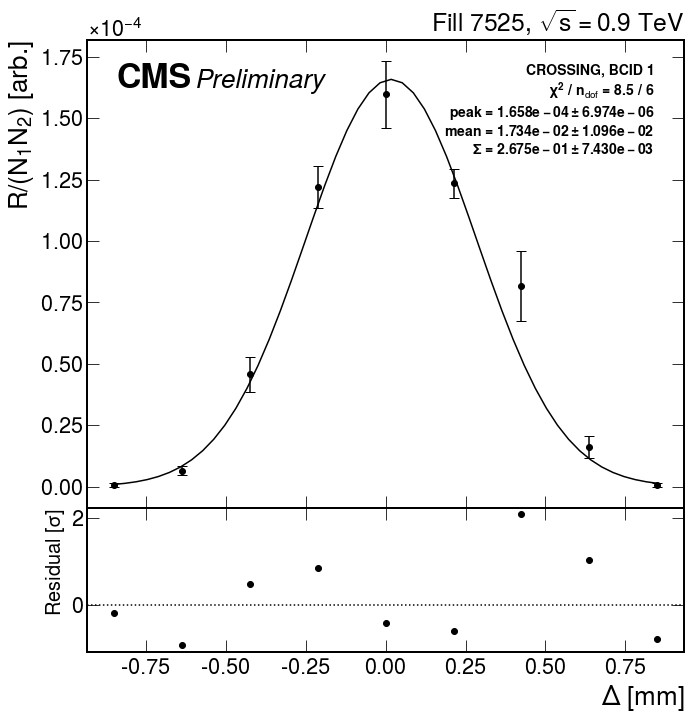

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3.957 (chi2/ndof = 0.7)    │              Nfcn = 90               │
│ EDM = 2.02e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬─

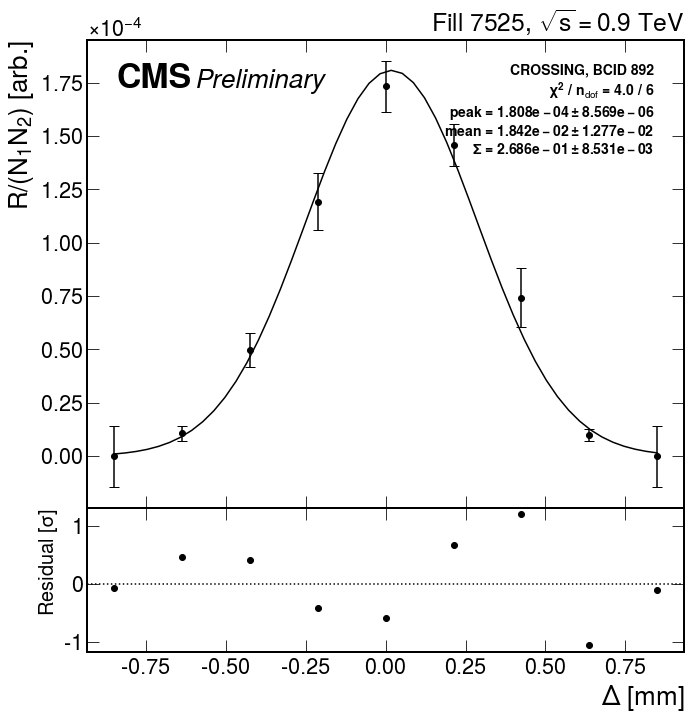

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 9.547 (chi2/ndof = 1.6)    │              Nfcn = 81               │
│ EDM = 6.93e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬─

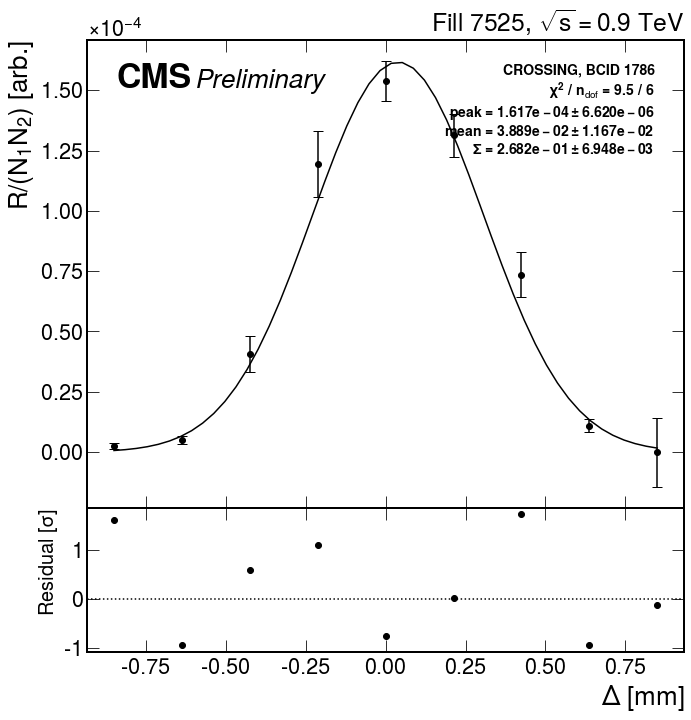

  0%|          | 0/3 [00:00<?, ?it/s]

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 10.56 (chi2/ndof = 1.8)    │              Nfcn = 88               │
│ EDM = 3.59e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬─

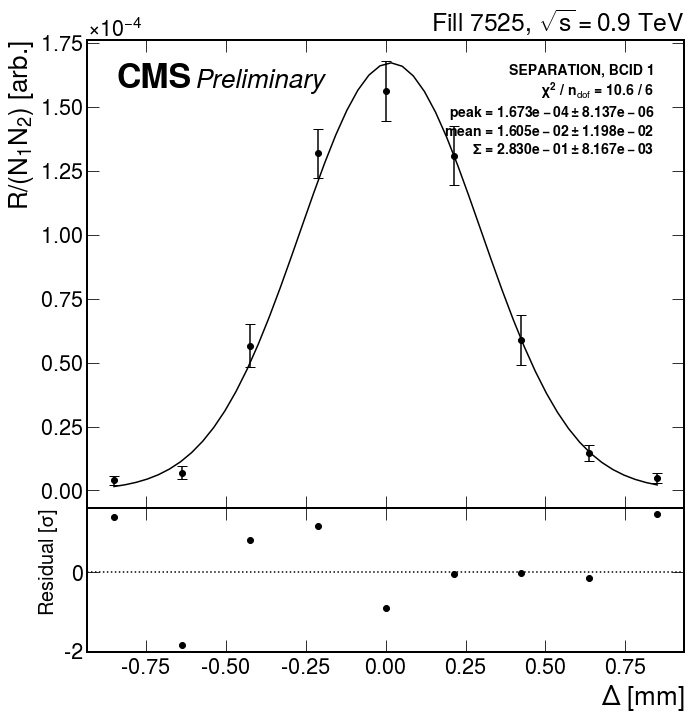

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3.977 (chi2/ndof = 0.7)    │              Nfcn = 81               │
│ EDM = 3.56e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬─

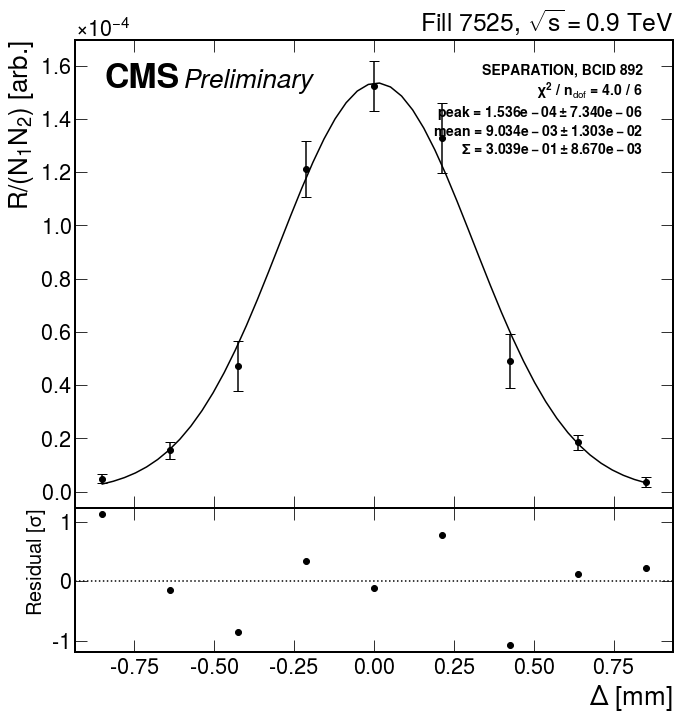

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 10.62 (chi2/ndof = 1.8)    │              Nfcn = 89               │
│ EDM = 2.39e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬─

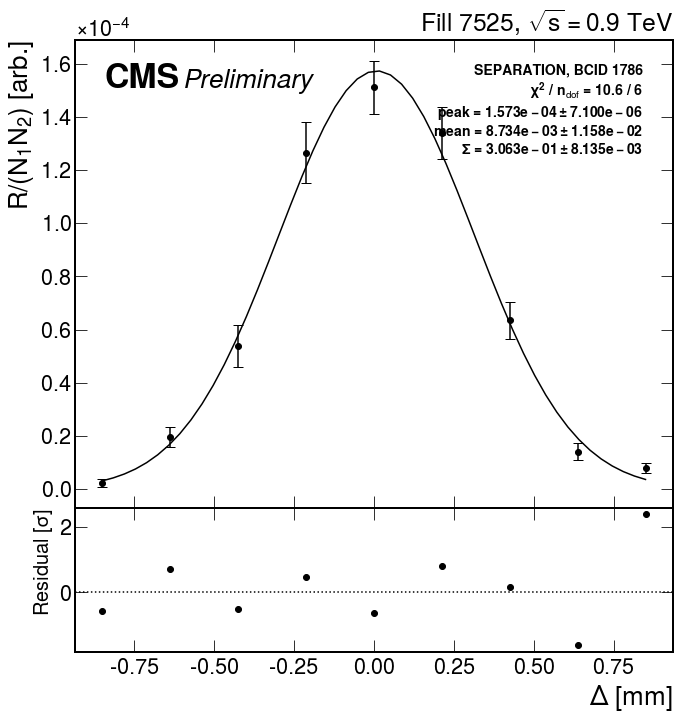

In [31]:
# Make a fit for each BCID in both planes
fit_results = pd.DataFrame()
for p, plane in tqdm(enumerate(data.plane.unique())): # For each plane
    for bcid in tqdm(collidable+1, leave=False): # For each BCID
        data_x = scan[scan.nominal_sep_plane == plane]['sep']
        data_y = data[(data.plane == plane) & (data.bcid == bcid)]['rate_normalised']
        data_y_err = data[(data.plane == plane) & (data.bcid == bcid)]['rate_normalised_err']
        least_squares = LeastSquares(data_x, data_y, data_y_err, FIT_FUNCTIONS[args.fit]['handle']) # Initialise minimiser with data and fit function of choice
        m = Minuit(least_squares, **FIT_FUNCTIONS[args.fit]['initial_values']) # Give the initial values defined in "FIT_FUNCTIONS"
        m.migrad()  # Finds minimum of least_squares function
        m.hesse()   # Accurately computes uncertainties
        print(m)
        new = pd.DataFrame([m.values], columns=m.parameters) # Store values to dataframe
        new = pd.concat([new, pd.DataFrame([m.errors], columns=m.parameters).add_suffix('_err')], axis=1) # Add suffix "_err" to errors
        new['valid'] =  m.valid # Fit status
        new['accurate'] = m.accurate
        new.insert(0, 'bcid', bcid)
        new.insert(0, 'plane', plane)
        fit_results = pd.concat([fit_results, new], ignore_index=True)
        if args.pdf: # This is just for plotting
            fig = plt.figure()
            ax1 = fig.add_axes((.12,.3,.83,.65)) # Upper part: fit and data points
            hep.cms.label(llabel="Preliminary", rlabel=fr"Fill {general_info.fillnum[0]}, $\sqrt{{s}}={general_info['energy'][0]*2/1000:.1f}$ TeV", loc=1)
            ax1.set_ylabel('$R/(N_1 N_2)$ [arb.]')
            ax1.set_xticklabels([])
            ax1.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useMathText=True, useOffset=False)
            ax1.minorticks_off()
            ax2 = fig.add_axes((.12,.1,.83,.2)) # Lower part: residuals
            ax2.ticklabel_format(axis='y', style='plain', useOffset=False)
            ax2.set_ylabel(r'Residual [$\sigma$]',fontsize=20)
            ax2.set_xlabel(r'$\Delta$ [mm]')
            ax2.minorticks_off()

            figure_items = []
            figure_items.append(ax1.errorbar(data_x, data_y, data_y_err, fmt='ko', capsize=5)) # Plot the data points
            x_dense = np.linspace(np.min(data_x), np.max(data_x))
            figure_items.append(ax1.plot(x_dense, FIT_FUNCTIONS[args.fit]['handle'](x_dense, *m.values), 'k')) # Plot the fit result
            fit_info = [f'{plane}, BCID {bcid}', f'$\\chi^2$ / $n_\\mathrm{{dof}}$ = {m.fval:.1f} / {len(data_x) - m.nfit}']
            for param, v, e in zip(m.parameters, m.values, m.errors):
                fit_info.append(f'{param} = ${v:.3e} \\pm {e:.3e}$')
            fit_info = [info.replace('cap_sigma', r'$\Sigma$') for info in fit_info]
            figure_items.append(ax1.text(0.95, 0.95, '\n'.join(fit_info), transform=ax1.transAxes, fontsize=14, fontweight='bold',
                verticalalignment='top', horizontalalignment='right'))
            residuals = (data_y.to_numpy() - FIT_FUNCTIONS[args.fit]['handle'](data_x, *m.values).to_numpy()) / data_y_err.to_numpy()
            figure_items.append(ax2.scatter(data_x, residuals, c='k'))
            lim = list(plt.xlim()) # Plot wide line without changing xlim
            figure_items.append(ax2.plot(lim, [0, 0], 'k:'))
            plt.xlim(lim)
            plt.show()
            for item in figure_items: # Only delete lines and fit results, leave general things
                if isinstance(item, list):
                    item[0].remove()
                else:
                    item.remove()

In [30]:
fit_results.cap_sigma *= 1e3 # to µm
fit_results.to_csv(f'{outpath}/{args.luminometer}_fit_results.csv', index=False)
print('\nfit_results:\n', fit_results)


fit_results:
         plane  bcid      peak      mean   cap_sigma  peak_err  mean_err  \
0    CROSSING     1  0.000166  0.017344  267.480122  0.000007  0.010963   
1    CROSSING   892  0.000181  0.018420  268.616336  0.000009  0.012767   
2    CROSSING  1786  0.000162  0.038894  268.151036  0.000007  0.011673   
3  SEPARATION     1  0.000167  0.016050  282.997290  0.000008  0.011980   
4  SEPARATION   892  0.000154  0.009034  303.882288  0.000007  0.013028   
5  SEPARATION  1786  0.000157  0.008734  306.315987  0.000007  0.011577   

   cap_sigma_err  valid  accurate  
0       0.007430   True      True  
1       0.008531   True      True  
2       0.006948   True      True  
3       0.008167   True      True  
4       0.008670   True      True  
5       0.008135   True      True  


In [31]:
val = fit_results.pivot(index='bcid', columns=['plane'], values=['cap_sigma', 'peak', 'cap_sigma_err', 'peak_err'])
sigvis = np.pi * val.cap_sigma.prod(axis=1) * val.peak.sum(axis=1) # sigvis = 2*pi*Sigma_x*Sigma_y*(peak_1+peak_2)/2
sigvis_err = (val.cap_sigma_err**2 / val.cap_sigma**2).sum(axis=1) + (val.peak_err**2).sum(axis=1) / (val.peak).sum(axis=1)**2 # Propagation of uncertainty
sigvis_err = np.sqrt(sigvis_err) * sigvis
lumi = pd.concat([sigvis, sigvis_err], axis=1)
lumi.columns = ['sigvis', 'sigvis_err']
lumi.to_csv(f'{outpath}/{args.luminometer}_lumi.csv')
print('\nlumi:\n', lumi)


lumi:
          sigvis  sigvis_err
bcid                       
1     79.219854    2.548497
892   85.737343    2.893480
1786  82.306182    2.504932


In [32]:
val

cap_sigma                  peak            cap_sigma_err             \
plane    CROSSING  SEPARATION  CROSSING SEPARATION      CROSSING SEPARATION   
bcid                                                                          
1      267.480122  282.997290  0.000166   0.000167      0.007430   0.008167   
892    268.616336  303.882288  0.000181   0.000154      0.008531   0.008670   
1786   268.151036  306.315987  0.000162   0.000157      0.006948   0.008135   

       peak_err             
plane  CROSSING SEPARATION  
bcid                        
1      0.000007   0.000008  
892    0.000009   0.000007  
1786   0.000007   0.000007